In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Sep 16 09:15:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!cd /content/
!git clone https://github.com/williamhyin/detectron2.git
# Install local Detectron2
!pip install -e detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 6942, done.
remote: Total 6942 (delta 0), reused 0 (delta 0), pack-reused 6942
Receiving objects: 100% (6942/6942), 3.80 MiB | 6.17 MiB/s, done.
Resolving deltas: 100% (4912/4912), done.
Obtaining file:///content/detectron2
     |████████████████████████████████| 2.2MB 6.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20200912-cp36-none-any.whl size=43996 sha256=06f64c5e171f79095c12e467a7c93be88d072bdb83a731219ee717b3697ea26a
  Stored in directory: /root/.cache/pip/wheels/34/41/7b/f0a0b5800bea0474ae553342bde52093fdd5852764463aa2ec
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Running setup.py develop for detectron2


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os, json, cv2, random, PIL
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

import numpy as np
import unittest
import cv2

from detectron2.structures import BoxMode, Instances, RotatedBoxes
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.detection_utils import read_image,convert_image_to_rgb

from pathlib import Path

import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data.sampler import RandomSampler
from detectron2.utils.visualizer import Visualizer, ColorMode



In [ ]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1oLm7cW51qG3U3ZDhGbuhLaQv3jjJcMJl',
                                    dest_path='/content/dfg_aug_data.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1BqUGCLrtoPIw_xyYh4rOZLwTVOX7p6Y3',
                                    dest_path='/content/dfg_aug_labels.zip',
                                    unzip=True)


Unzipping...Done.


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1IzvkInZ-wZXkEAG8VPqhXpW_WOrp1LT-',
                                    dest_path='/content/subset_train.json',
                                    unzip=False)


In [ ]:
FILE_ROOT="/content/"
my_dataset_train_name="dfg_train"
my_dataset_val_name="dfg_test"
my_dataset_train="/content/images/train"
json_annotation_train="/content/subset_train.json"
my_dataset_val="/content/images/test"
json_annotation_val="/content/labels/test_ori.json"
class_map=['I-1', 'I-1.1', 'I-10', 'I-11', 'I-13', 'I-13.1', 'I-14', 'I-15', 'I-16', 'I-17', 'I-18', 'I-19', 'I-2', 'I-2.1', 'I-20', 'I-25', 'I-27', 'I-28', 'I-28.1', 'I-29', 'I-29.1', 'I-3', 'I-30', 'I-32', 'I-34', 'I-36', 'I-37', 'I-38', 'I-39-1', 'I-39-2', 'I-39-3', 'I-4', 'I-5', 'I-5.1', 'I-5.2', 'I-8', 'I-9', 'II-1', 'II-10.1', 'II-14', 'II-17', 'II-18', 'II-19-4', 'II-2', 'II-21', 'II-22', 'II-23', 'II-26', 'II-26.1', 'II-28', 'II-3', 'II-30-10', 'II-30-30', 'II-30-40', 'II-30-50', 'II-30-60', 'II-30-70', 'II-32', 'II-33', 'II-34', 'II-35', 'II-39', 'II-4', 'II-40', 'II-41', 'II-42', 'II-42.1', 'II-43', 'II-45', 'II-45.1', 'II-45.2', 'II-46', 'II-46.1', 'II-46.2', 'II-47', 'II-47.1', 'II-48', 'II-6', 'II-7', 'II-7.1', 'II-8', 'III-1', 'III-10', 'III-105', 'III-105.1', 'III-105.3', 'III-107-1', 'III-107-2', 'III-107.1-1', 'III-107.1-2', 'III-107.2-1', 'III-107.2-2', 'III-112', 'III-113', 'III-12', 'III-120', 'III-120-1', 'III-120.1', 'III-123', 'III-124', 'III-14', 'III-14.1', 'III-15', 'III-16', 'III-18-40', 'III-18-50', 'III-18-60', 'III-18-70', 'III-2', 'III-202-5', 'III-203-2', 'III-206-1', 'III-21', 'III-23', 'III-25', 'III-25.1', 'III-27', 'III-29-30', 'III-29-40', 'III-3', 'III-30-30', 'III-33', 'III-34', 'III-35', 'III-37', 'III-39', 'III-40', 'III-42', 'III-43', 'III-45', 'III-46', 'III-47', 'III-5', 'III-50', 'III-54', 'III-59', 'III-6', 'III-64', 'III-68', 'III-74', 'III-77', 'III-78', 'III-8-1', 'III-84', 'III-84-1', 'III-85-2', 'III-85-3', 'III-85.1', 'III-86-1', 'III-86-2', 'III-87', 'III-90', 'III-90.1', 'III-90.2', 'III-91', 'IV-1', 'IV-1.1', 'IV-10', 'IV-11', 'IV-12', 'IV-12.1', 'IV-13-1', 'IV-13-2', 'IV-13-3', 'IV-13-4', 'IV-13-5', 'IV-13-6', 'IV-13.1-2', 'IV-13.1-3', 'IV-13.1-4', 'IV-16', 'IV-17', 'IV-18', 'IV-2', 'IV-20-1', 'IV-3-1', 'IV-3-2', 'IV-3-4', 'IV-3-5', 'IV-5', 'IV-6', 'VI-2.1', 'VI-3-1', 'VI-3-2', 'VI-3.1-1', 'VI-3.1-2', 'VI-8', 'VII-4', 'VII-4-1', 'VII-4-2', 'VII-4.1-1', 'VII-4.3', 'VII-4.3-1', 'VII-4.3-2', 'VII-4.4-1', 'VII-4.4-2', 'X-1.1', 'X-1.2', 'X-4', 'X-6-3']

try:
  register_coco_instances(my_dataset_train_name, {}, json_annotation_train,my_dataset_train)
  register_coco_instances(my_dataset_val_name, {}, json_annotation_val, my_dataset_val)
except Exception as f:
  print(f)


WARNING [09/16 22:51:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/16 22:51:13 d2.data.datasets.coco]: Loaded 1911 images in COCO format from /content/subset_train.json


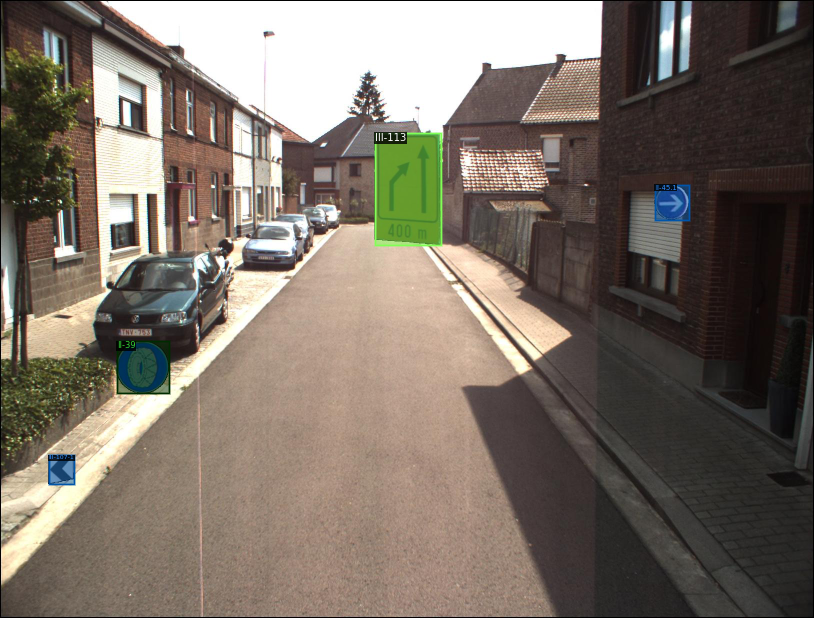

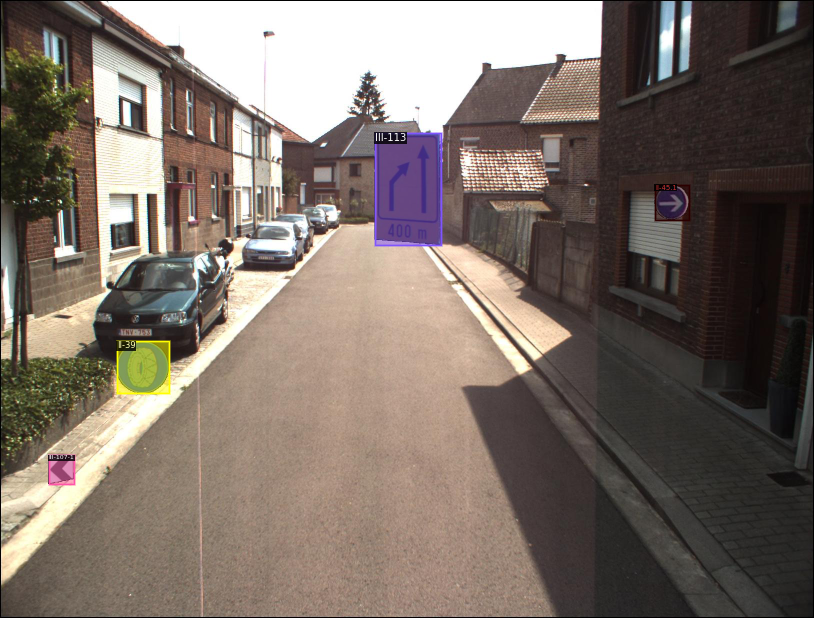

In [ ]:
metadata=MetadataCatalog.get(my_dataset_train_name).set(thing_classes=class_map)
data_dicts=DatasetCatalog.get(my_dataset_train_name)
sampler=RandomSampler(data_dicts,True,1)
index=next(iter(sampler))
dict=data_dicts[index]

img=read_image(dict['file_name'],format='BGR')
visualizer1=Visualizer(img,metadata,instance_mode=ColorMode.IMAGE,scale=0.5)
visualizer2=Visualizer(img,metadata,instance_mode=ColorMode.SEGMENTATION, scale=0.5)
dict_ori=deepcopy(dict)
dict_ori['annotations']=None

image_visual1=visualizer1.draw_dataset_dict(dict)
#ColorMode IMAGE
cv2_imshow(image_visual1.get_image())
# cv2.waitKey(0)

image_visual2=visualizer2.draw_dataset_dict(dict)
#ColorMode SEGMENTATION
cv2_imshow(image_visual2.get_image())
# cv2.waitKey(0)

# image_visual.save(os.path.join(FILE_ROOT,'TMP.JPG'))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# os.makedirs("/content/output", exist_ok=True)
# %cp -r /content/gdrive/My\ Drive/Colab\ Notebooks/weights_tmp/detn2_mcnn_8_300_08_10_31/ /content/output/ 


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2/configs/dfg/mask_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (my_dataset_train_name,)
cfg.DATASETS.TEST = (my_dataset_val_name,)
cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
batch_size=8
cfg.SOLVER.IMS_PER_BATCH = batch_size
epochs=300
train_samples=1911 
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
iteration=int(np.round(train_samples/batch_size*epochs))
print("iteration: ", iteration)
cfg.SOLVER.MAX_ITER = iteration    #  you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 200  # only has one class (ballon)
cfg.INPUT.MIN_SIZE_TRAIN=800
cfg.INPUT.MAX_SIZE_TRAIN=1200
cfg.INPUT.MIN_SIZE_TEST=800
cfg.INPUT.MAX_SIZE_TEST=1200
decrease_1=int(np.round(train_samples/batch_size*200))
decrease_2=int(np.round(train_samples/batch_size*250))
cfg.SOLVER.STEPS=(decrease_1,decrease_2,)


iteration:  71662


In [ ]:
#first training
torch.cuda.empty_cache()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/15 16:19:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (201, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (201,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (800, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (800,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (200, 256

[09/15 16:19:34 d2.engine.train_loop]: Starting training from iteration 0


/content/detectron2/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).

[09/15 16:20:02 d2.utils.events]:  eta: 1 day, 1:58:17  iter: 19  total_loss: 6.055  loss_cls: 5.039  loss_box_reg: 0.2154  loss_mask: 0.692  loss_rpn_cls: 0.0679  loss_rpn_loc: 0.01251  time: 1.3226  data_time: 0.1006  lr: 0.00019981  max_mem: 11870M
[09/15 16:20:29 d2.utils.events]:  eta: 1 day, 2:12:32  iter: 39  total_loss: 2.332  loss_cls: 1.128  loss_box_reg: 0.352  loss_mask: 0.6846  loss_rpn_cls: 0.02703  loss_rpn_loc: 0.01092  time: 1.3270  data_time: 0.0379  lr: 0.00039961  max_mem: 11870M
[09/15 16:20:56 d2.utils.events]:  eta: 1 day, 2:33:33  iter: 59  total_loss: 2.507  loss_cls: 1.147  loss_box_reg: 0.6439  loss_mask: 0.6692  loss_rpn_cls: 0.01817  loss_rpn_loc: 0.009746  time: 1.3427  data_time: 0.0433  lr: 0.00059941  max_mem: 11870M
[09/15 16:21:23 d2.utils.events]:  eta: 1 day, 2:44:00  iter: 79  total_loss: 2.211  loss_cls: 1.004  loss_box_reg: 0.5618  loss_mask: 0.6301  loss_rpn_cls: 0.01879  loss_rpn_loc: 0.008599  time: 1.3453  data_time: 0.0419  lr: 0.00079921  m

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-c0b3d1b55771>", line 6, in <module>
    trainer.train()
  File "/content/detectron2/detectron2/engine/defaults.py", line 402, in train
    super().train(self.start_iter, self.max_iter)
  File "/content/detectron2/detectron2/engine/train_loop.py", line 141, in train
    self.run_step()
  File "/content/detectron2/detectron2/engine/train_loop.py", line 227, in run_step
    loss_dict = self.model(data)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/content/detectron2/detectron2/modeling/meta_arch/rcnn.py", line 151, in forward
    images = self.preprocess_image(batched_inputs)
  File "/content/detectron2/detectron2/modeling/meta_arch/rcnn.py", line 220, in preprocess_im

KeyboardInterrupt: ignored

In [ ]:
#resume training
my_weights_path="/content/gdrive/My Drive/Colab Notebooks/weights_tmp/detn2_mcnn_8_300_17_11_19/model_0039999.pth"
my_output="/content/gdrive/My Drive/Colab Notebooks/weights_tmp/detn2_mcnn_8_300_17_11_19"
torch.cuda.empty_cache()
cfg.OUTPUT_DIR=my_output
cfg.MODEL.WEIGHTS =my_weights_path
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[09/16 09:29:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/content/detectron2/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).

[09/16 09:30:18 d2.utils.events]:  eta: 11:21:27  iter: 40019  total_loss: 0.08146  loss_cls: 0.0115  loss_box_reg: 0.05136  loss_mask: 0.01449  loss_rpn_cls: 0.0002293  loss_rpn_loc: 0.00432  time: 1.2889  data_time: 0.1052  lr: 0.01  max_mem: 12115M
[09/16 09:30:44 d2.utils.events]:  eta: 11:18:32  iter: 40039  total_loss: 0.0791  loss_cls: 0.01013  loss_box_reg: 0.05079  loss_mask: 0.01365  loss_rpn_cls: 0.0002076  loss_rpn_loc: 0.003053  time: 1.2874  data_time: 0.0393  lr: 0.01  max_mem: 12115M
[09/16 09:31:10 d2.utils.events]:  eta: 11:18:06  iter: 40059  total_loss: 0.07863  loss_cls: 0.01039  loss_box_reg: 0.05007  loss_mask: 0.01284  loss_rpn_cls: 0.0001654  loss_rpn_loc: 0.002996  time: 1.2896  data_time: 0.0392  lr: 0.01  max_mem: 12115M
[09/16 09:31:36 d2.utils.events]:  eta: 11:19:05  iter: 40079  total_loss: 0.07685  loss_cls: 0.008194  loss_box_reg: 0.05121  loss_mask: 0.01312  loss_rpn_cls: 0.0001801  loss_rpn_loc: 0.003848  time: 1.2937  data_time: 0.0338  lr: 0.01  ma

In [ ]:
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.WEIGHTS ="/content/gdrive/My Drive/Colab Notebooks/weights_tmp/detn2_mcnn_8_300_17_11_19/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing
predictor=DefaultPredictor(cfg)

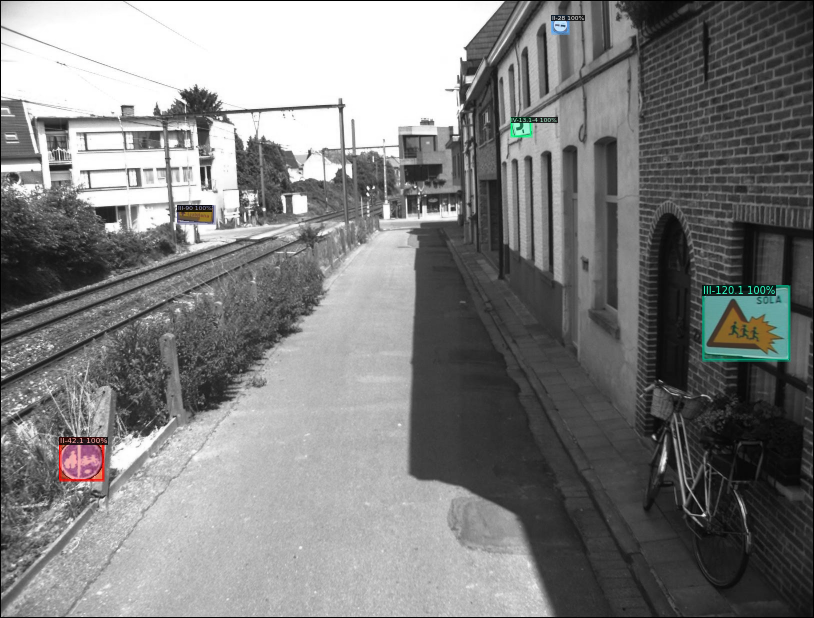

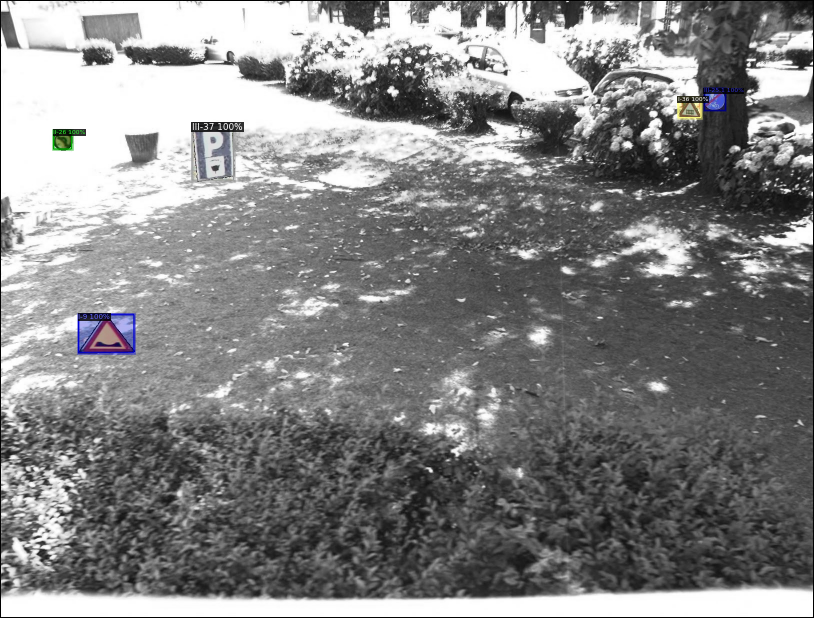

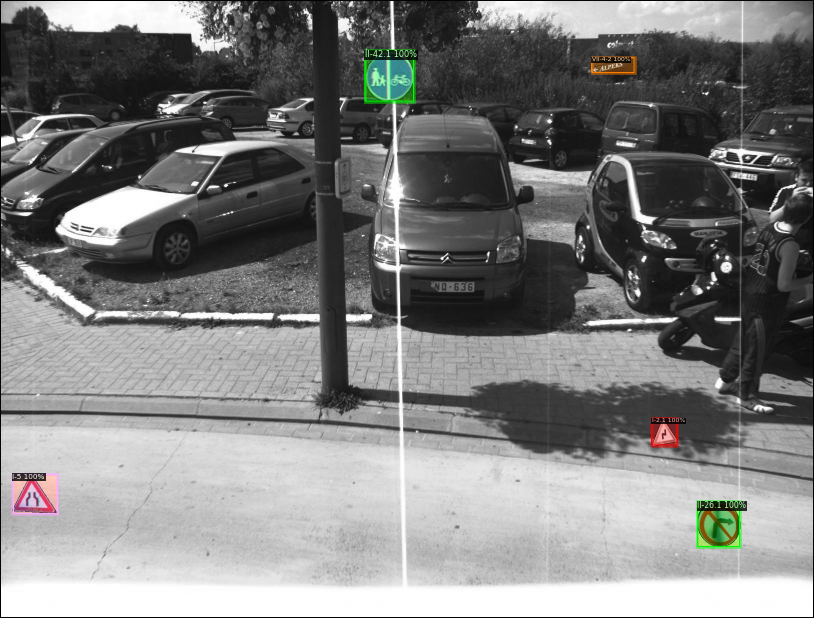

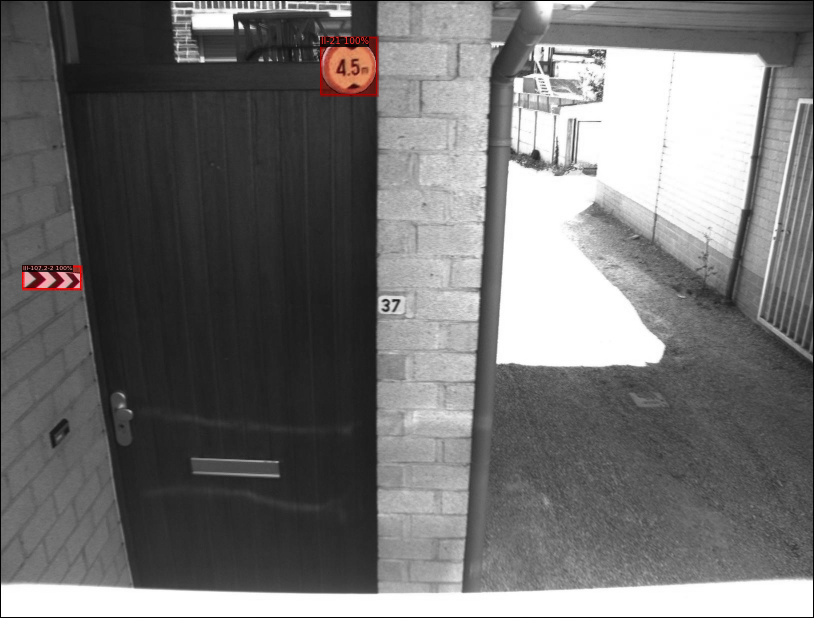

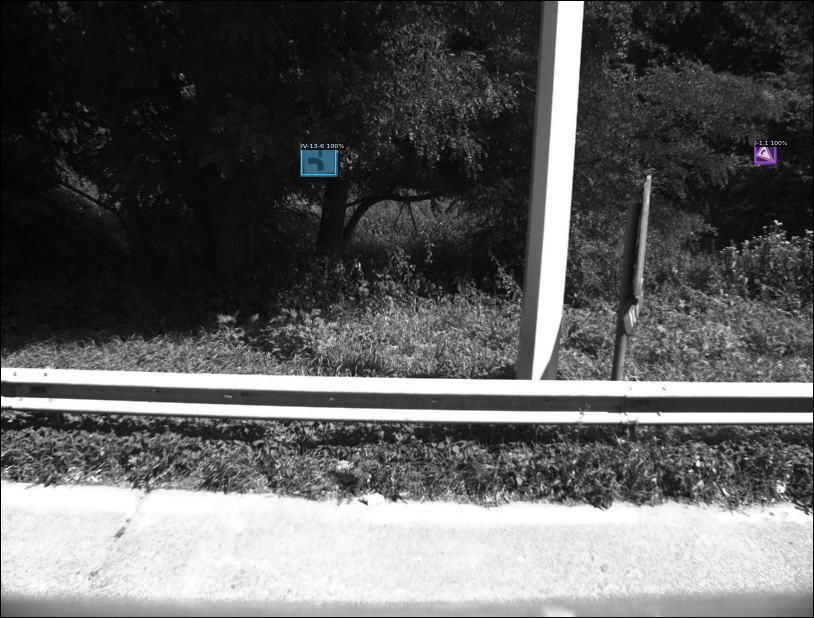

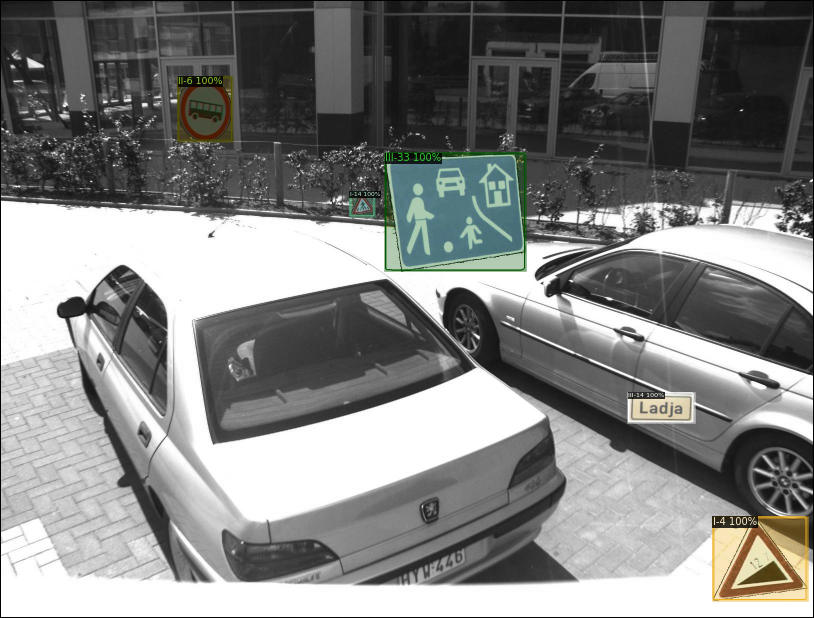

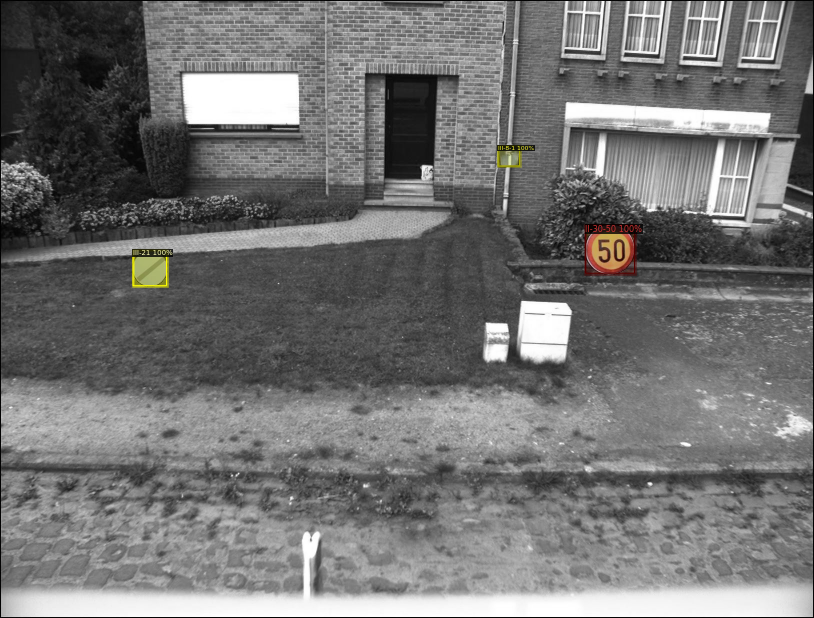

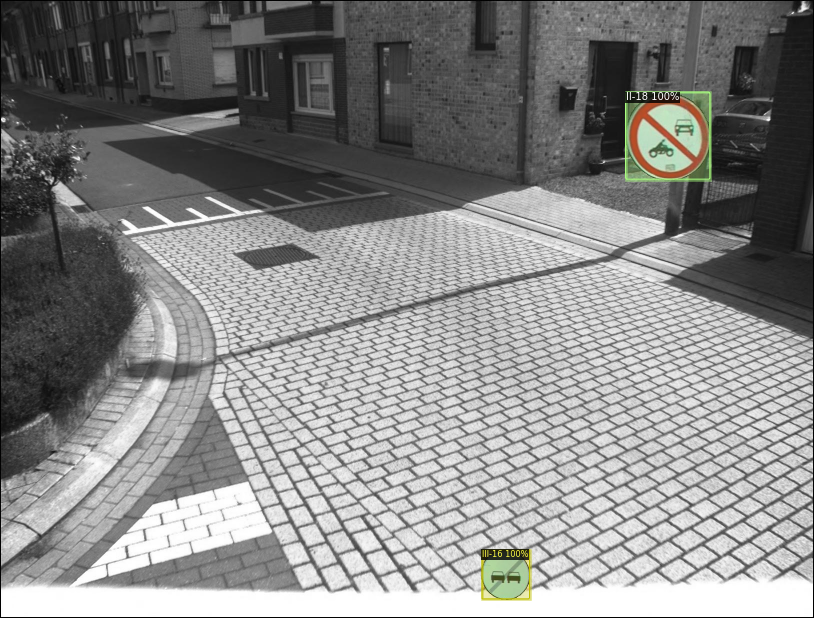

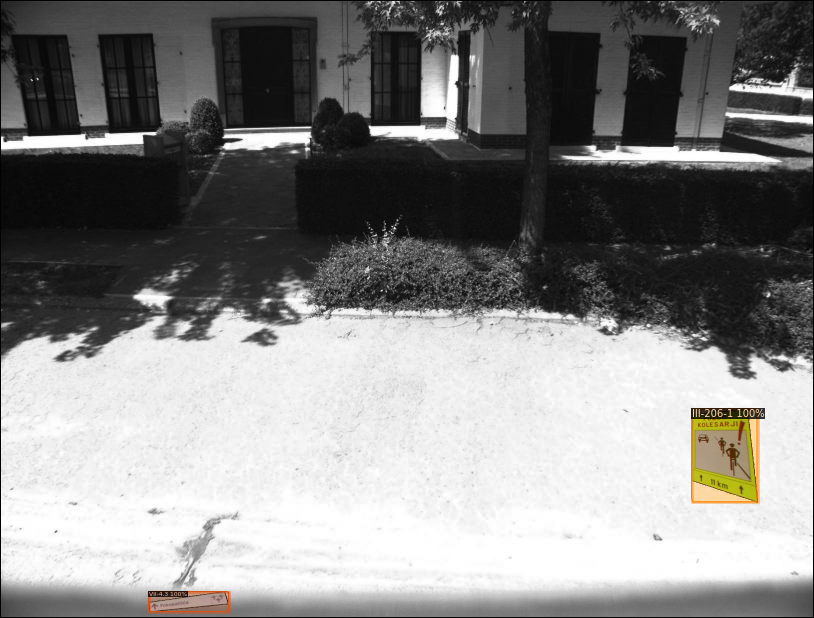

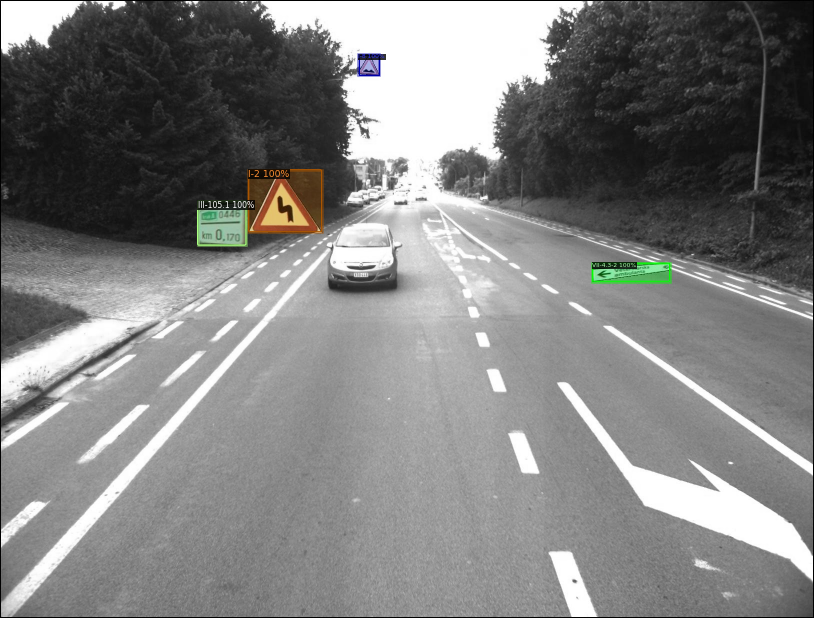

In [ ]:

sampler=RandomSampler(data_dicts,True,1)
for d in random.sample(data_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#@title
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("dfg_test", cfg, False, output_dir=my_output)
val_loader = build_detection_test_loader(cfg, "dfg_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [09/16 22:52:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/16 22:52:54 d2.data.datasets.coco]: Loaded 1703 images in COCO format from /content/labels/test_ori.json
[09/16 22:52:54 d2.data.common]: Serializing 1703 elements to byte tensors and concatenating them all ...
[09/16 22:52:54 d2.data.common]: Serialized dataset takes 0.86 MiB
[09/16 22:52:54 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1200, sample_style='choice')]
[09/16 22:52:54 d2.evaluation.evaluator]: Start inference on 1703 images
[09/16 22:52:56 d2.evaluation.evaluator]: Inference done 11/1703. 0.0807 s / img. ETA=0:03:45
[09/16 22:53:02 d2.evaluation.evaluator]: Inference done 49/1703. 0.0830 s / img. ETA=0:03:41
[09/16 22:53:07 d2.evaluation.evaluator]: Inference done 88/1703. 0.0829 s / img. ETA=0:03:32
[09/16 22:53:12 d2.evaluation.evaluator]: Inference done 126/17

In [ ]:
#@title
# register_coco_instances("dfg_ori_train", {}, "/content/labels/train_ori.json",my_dataset_train)
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("dfg_ori_train", cfg, False, output_dir="/content/gdrive/My Drive/Colab Notebooks/weights_tmp/detn2_mcnn_8_300_17_11_19/inference_train_sample")
val_loader = build_detection_test_loader(cfg, "dfg_ori_train")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [09/16 23:38:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/16 23:38:09 d2.data.datasets.coco]: Loaded 14029 images in COCO format from /content/labels/train_ori.json
[09/16 23:38:10 d2.data.common]: Serializing 14029 elements to byte tensors and concatenating them all ...
[09/16 23:38:10 d2.data.common]: Serialized dataset takes 6.26 MiB
[09/16 23:38:10 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1200, sample_style='choice')]
[09/16 23:38:10 d2.evaluation.evaluator]: Start inference on 14029 images
[09/16 23:38:12 d2.evaluation.evaluator]: Inference done 11/14029. 0.0814 s / img. ETA=0:33:05
[09/16 23:38:17 d2.evaluation.evaluator]: Inference done 49/14029. 0.0860 s / img. ETA=0:31:03
[09/16 23:38:22 d2.evaluation.evaluator]: Inference done 87/14029. 0.0835 s / img. ETA=0:30:48
[09/16 23:38:27 d2.evaluation.evaluator]: Inference done

In [ ]:
from datetime import datetime
import pytz

tz_NY = pytz.timezone('Asia/Shanghai') 
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))


NY time: 17:11:19


In [ ]:
strore_name="detn2_mcnn"+"_"+str(batch_size)+"_"+str(epochs)+"_"+ datetime_NY.strftime("%H_%M_%S")
strore_name

'detn2_mcnn_8_300_17_11_19'

In [ ]:
%cp -r /content/output/ /content/gdrive/My\ Drive/Colab\ Notebooks/weights_tmp/{strore_name}/